# Bureau Dataset Analysis

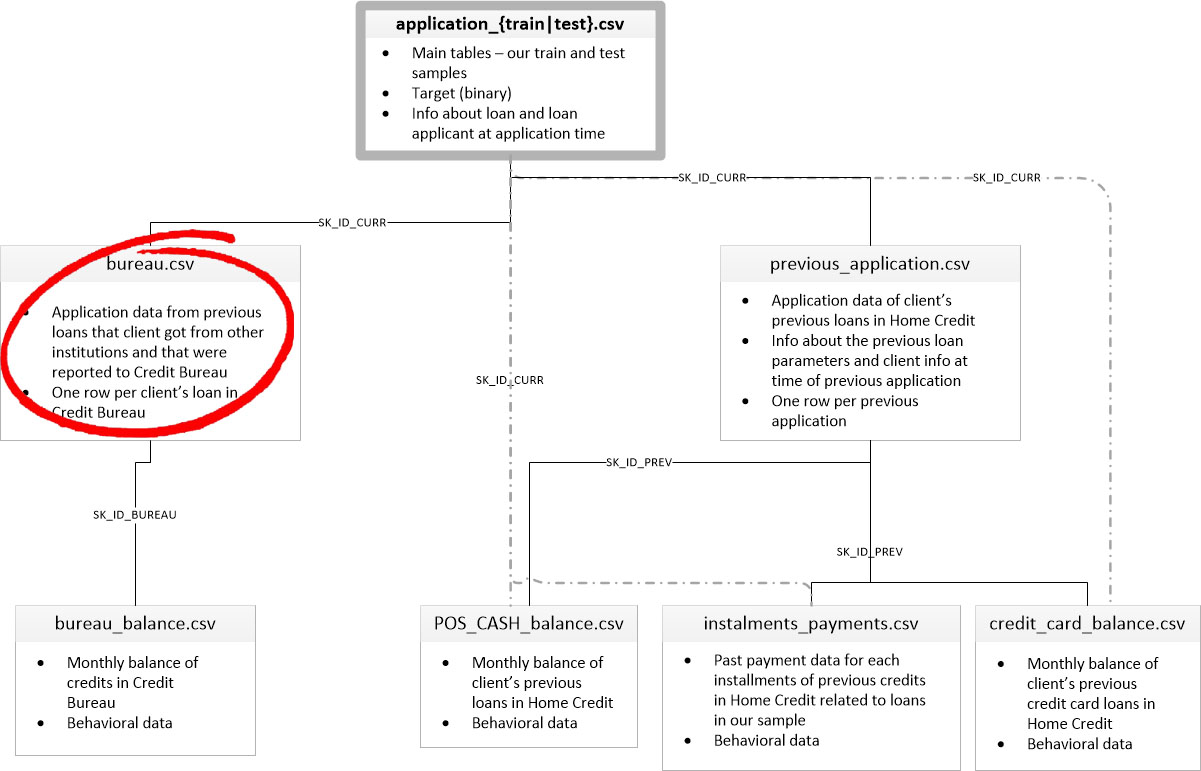

In this notebook I will try to explore bureau dataset and see what we can take from it.

Here is a short description from home credit about this dataset:
* "All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample)."
* "For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date."

# Import Libraries

In [1]:
%load_ext nb_black
import homecredit_functions as hc
import imp

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

sns.set(style="whitegrid", color_codes=True)
pd.set_option("display.float_format", lambda x: "%.5f" % x)

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

RANDOM_STATE = 0

<IPython.core.display.Javascript object>

# Load Processed Application Datasets

### Application Test Processed Dataset

In [2]:
path_application_test_proc = "data/application_test_proc.csv"
df_application_test_proc = pd.read_csv(path_application_test_proc)

<IPython.core.display.Javascript object>

In [3]:
df_application_test_proc.head(5)

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,...,EXT_SOURCE_MIN,ANNUITY_CREDIT_RATIO,CREDIT_ANNUITY_RATIO,TARGET_NEIGHBORS_500_MEAN,GOODS_PRICE_AMT_ANNUITY_RATIO,GOODS_PRICE_AMT_INCOME_TOTAL_RATIO,GOODS_PRICE_AMT_CREDIT_RATIO,ANNUITY_DAYS_EMPLOYED_RATIO,ANNUITY_DAYS_BIRTH_RATIO,SK_ID_CURR
0,0.00000,0.00093,0.13079,0.25700,0.33754,0.04067,0.79045,0.88718,1.00000,1.00000,...,0.18150,0.13697,0.40086,0.11915,0.14272,0.03929,0.09607,0.99961,0.95603,100001
1,0.00000,0.00063,0.04439,0.49159,0.40389,0.03509,0.63043,0.77449,1.00000,1.00000,...,0.33184,0.43293,0.12210,0.25106,0.05407,0.02141,0.09867,0.99981,0.96073,100005
2,0.00000,0.00151,0.15437,0.26048,0.29262,0.03511,0.91184,0.51327,1.00000,1.00000,...,0.69517,0.62560,0.05975,0.03404,0.04381,0.03667,0.12049,0.99933,0.84987,100013
3,0.10526,0.00247,0.38202,0.36143,0.63433,0.04188,0.91894,0.41531,1.00000,1.00000,...,0.57990,0.10142,0.48475,0.05532,0.22152,0.05896,0.12821,0.99889,0.84877,100028
4,0.05263,0.00132,0.14494,0.13490,0.68709,0.04103,0.83787,0.40781,1.00000,1.00000,...,0.23000,0.24395,0.24761,0.23404,0.12441,0.04097,0.12821,0.99937,0.89487,100038


<IPython.core.display.Javascript object>

### Application Train Processed Dataset

In [4]:
path_application_train_proc = "data/application_train_proc.csv"
df_application_train_proc = pd.read_csv(path_application_train_proc)

<IPython.core.display.Javascript object>

In [5]:
df_application_train_proc.head(5)

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,...,ANNUITY_CREDIT_RATIO,CREDIT_ANNUITY_RATIO,TARGET_NEIGHBORS_500_MEAN,GOODS_PRICE_AMT_ANNUITY_RATIO,GOODS_PRICE_AMT_INCOME_TOTAL_RATIO,GOODS_PRICE_AMT_CREDIT_RATIO,ANNUITY_DAYS_EMPLOYED_RATIO,ANNUITY_DAYS_BIRTH_RATIO,TARGET,SK_ID_CURR
0,0.00000,0.00151,0.09029,0.25632,0.88884,0.04509,0.85214,0.70543,1.00000,1.00000,...,0.31105,0.19041,0.54468,0.08367,0.02041,0.10717,0.99838,0.88820,1,100002
1,0.00000,0.00209,0.31174,0.04502,0.47711,0.04365,0.95193,0.95957,1.00000,1.00000,...,0.07648,0.56183,0.08511,0.21774,0.04932,0.10870,0.99874,0.90937,0,100003
2,0.00000,0.00036,0.02247,0.13490,0.34853,0.04616,0.82733,0.64833,1.00000,1.00000,...,0.23499,0.25688,0.05532,0.12821,0.02356,0.12821,0.99874,0.98744,0,100004
3,0.00000,0.00093,0.06684,0.10702,0.35085,0.03882,0.60145,0.66139,1.00000,1.00000,...,0.55299,0.07905,0.06809,0.05132,0.02592,0.12049,0.99957,0.93432,0,100006
4,0.00000,0.00082,0.11685,0.39288,0.29859,0.03882,0.82527,0.51952,1.00000,1.00000,...,0.18279,0.32191,0.15319,0.15483,0.04978,0.12821,0.99968,0.95478,0,100007


<IPython.core.display.Javascript object>

# EDA

### Bureau Dataset

In [6]:
path_bureau = "data/bureau.csv"
df_bureau = pd.read_csv(path_bureau)

<IPython.core.display.Javascript object>

In [7]:
df_bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.00000,-153.00000,nan,0,91323.00000,0.00000,nan,0.00000,Consumer credit,-131,nan
1,215354,5714463,Active,currency 1,-208,0,1075.00000,nan,nan,0,225000.00000,171342.00000,nan,0.00000,Credit card,-20,nan
2,215354,5714464,Active,currency 1,-203,0,528.00000,nan,nan,0,464323.50000,nan,nan,0.00000,Consumer credit,-16,nan
3,215354,5714465,Active,currency 1,-203,0,nan,nan,nan,0,90000.00000,nan,nan,0.00000,Credit card,-16,nan
4,215354,5714466,Active,currency 1,-629,0,1197.00000,nan,77674.50000,0,2700000.00000,nan,nan,0.00000,Consumer credit,-21,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.00000,nan,0.00000,0,11250.00000,11250.00000,0.00000,0.00000,Microloan,-19,nan
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.00000,-2493.00000,5476.50000,0,38130.84000,0.00000,0.00000,0.00000,Consumer credit,-2493,nan
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.00000,-970.00000,nan,0,15570.00000,nan,nan,0.00000,Consumer credit,-967,nan
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.00000,-1513.00000,nan,0,36000.00000,0.00000,0.00000,0.00000,Consumer credit,-1508,nan


<IPython.core.display.Javascript object>

In [8]:
df_bureau.select_dtypes(["float64", "int64"]).describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,1716428.00000,278214.93364,102938.55811,100001.00000,188866.75000,278055.00000,367426.00000,456255.00000
SK_ID_BUREAU,1716428.00000,5924434.48903,532265.72855,5000000.00000,5463953.75000,5926303.50000,6385681.25000,6843457.00000
DAYS_CREDIT,1716428.00000,-1142.10768,795.16493,-2922.00000,-1666.00000,-987.00000,-474.00000,0.00000
CREDIT_DAY_OVERDUE,1716428.00000,0.81817,36.54443,0.00000,0.00000,0.00000,0.00000,2792.00000
DAYS_CREDIT_ENDDATE,1610875.00000,510.51736,4994.21984,-42060.00000,-1138.00000,-330.00000,474.00000,31199.00000
DAYS_ENDDATE_FACT,1082775.00000,-1017.43715,714.01063,-42023.00000,-1489.00000,-897.00000,-425.00000,0.00000
AMT_CREDIT_MAX_OVERDUE,591940.00000,3825.41766,206031.60621,0.00000,0.00000,0.00000,0.00000,115987185.00000
CNT_CREDIT_PROLONG,1716428.00000,0.00641,0.09622,0.00000,0.00000,0.00000,0.00000,9.00000
AMT_CREDIT_SUM,1716415.00000,354994.59192,1149811.34398,0.00000,51300.00000,125518.50000,315000.00000,585000000.00000
AMT_CREDIT_SUM_DEBT,1458759.00000,137085.11995,677401.13095,-4705600.32000,0.00000,0.00000,40153.50000,170100000.00000


<IPython.core.display.Javascript object>

In [9]:
df_bureau.select_dtypes(["object"]).describe().T

,count,unique,top,freq
CREDIT_ACTIVE,1716428,4,Closed,1079273
CREDIT_CURRENCY,1716428,4,currency 1,1715020
CREDIT_TYPE,1716428,15,Consumer credit,1251615


<IPython.core.display.Javascript object>

**Observation:**:
* Dataset has mostly numerical features with three categorical features included.
* CNT_CREDIT_PROLONG, CREDIT_DAY_OVERDUE looks like having quite extreme max values comparing to their mean and standard deviation values.

In [10]:
# Merge bureau dataset with application train dataset
df_bureau_analysis = df_bureau.merge(
    df_application_train_proc[["SK_ID_CURR", "TARGET"]], how="left", on="SK_ID_CURR"
)
df_bureau_analysis.head(5)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,TARGET
0,215354,5714462,Closed,currency 1,-497,0,-153.00000,-153.00000,nan,0,91323.00000,0.00000,nan,0.00000,Consumer credit,-131,nan,0.00000
1,215354,5714463,Active,currency 1,-208,0,1075.00000,nan,nan,0,225000.00000,171342.00000,nan,0.00000,Credit card,-20,nan,0.00000
2,215354,5714464,Active,currency 1,-203,0,528.00000,nan,nan,0,464323.50000,nan,nan,0.00000,Consumer credit,-16,nan,0.00000
3,215354,5714465,Active,currency 1,-203,0,nan,nan,nan,0,90000.00000,nan,nan,0.00000,Credit card,-16,nan,0.00000
4,215354,5714466,Active,currency 1,-629,0,1197.00000,nan,77674.50000,0,2700000.00000,nan,nan,0.00000,Consumer credit,-21,nan,0.00000


<IPython.core.display.Javascript object>

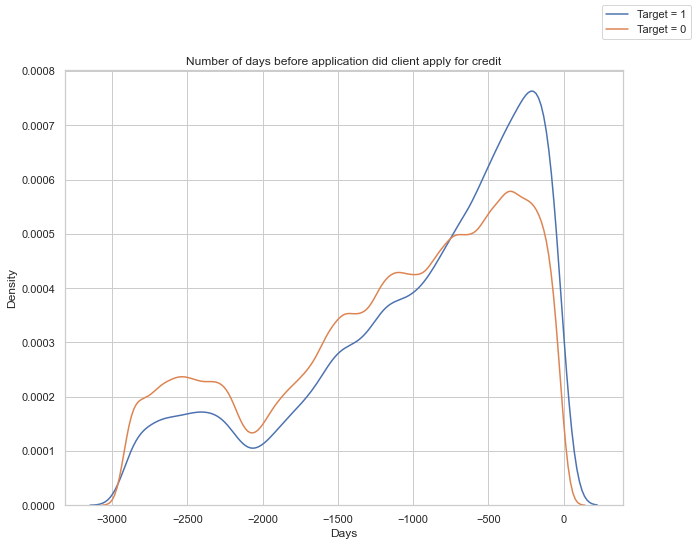

<IPython.core.display.Javascript object>

In [11]:
fig = plt.figure(figsize=(10, 8))
plt.title("Number of days before application did client apply for credit")
plt.xlabel("Days")
sns.kdeplot(df_bureau_analysis[df_bureau_analysis["TARGET"] == 1]["DAYS_CREDIT"])
sns.kdeplot(df_bureau_analysis[df_bureau_analysis["TARGET"] == 0]["DAYS_CREDIT"])

fig.legend(labels=["Target = 1", "Target = 0"])
plt.show()

**Observation:**:
* It seems that people who  applied for a credit roughly 900 days before had more chance to not repay their loan.

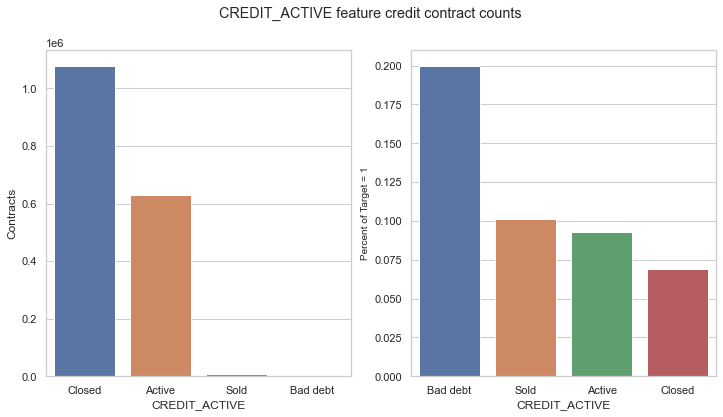

<IPython.core.display.Javascript object>

In [11]:
hc.plot_count(df_bureau_analysis, "CREDIT_ACTIVE")

**Observation:**:
* Most of the credits registered at the Credit Bureau are in the status Closed. On the other hand people that have bad dept have biggest percentage to not repay their credit.

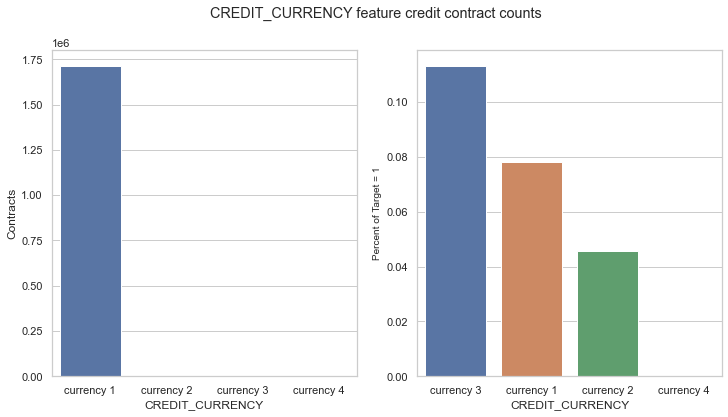

<IPython.core.display.Javascript object>

In [12]:
hc.plot_count(df_bureau_analysis, "CREDIT_CURRENCY")

**Observation:**:
* Almost every credit was taken in currency 1. Biggest percentage of defaulters are in currency 3 (almost 0.12 percent).

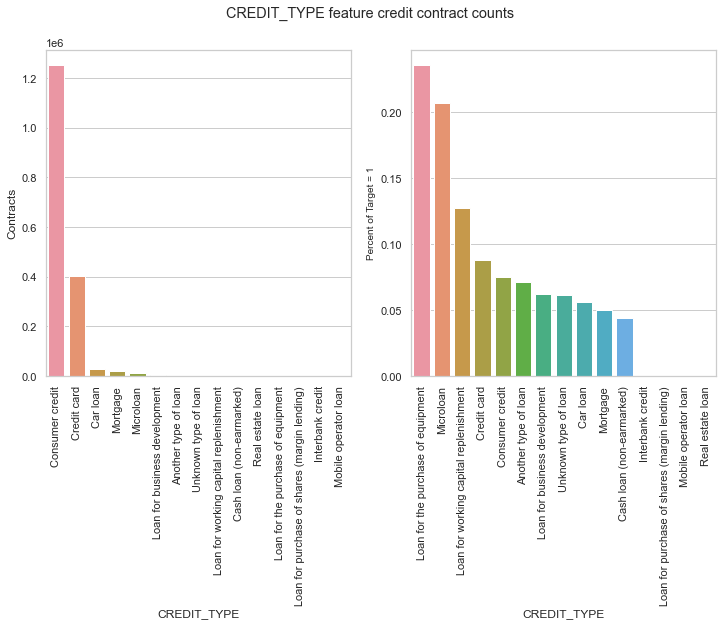

<IPython.core.display.Javascript object>

In [13]:
hc.plot_count(df_bureau_analysis, "CREDIT_TYPE", True)

**Observation:**:
* Majority credits are taken by consumer credit and credit card. People that took credit for purchase of equipment and microloan has biggest chances fail to pay their credits.

# Data Wrangling

## Correlation

### Correlation with target

In [14]:
corrs_bureau = df_bureau_analysis.corr()[["TARGET"]].sort_values(
    by="TARGET", ascending=False
)
corrs_bureau = corrs_bureau.rename(columns={"TARGET": "target_corr"})
corrs_bureau = corrs_bureau.drop(["TARGET", "SK_ID_CURR"])
corrs_bureau

,target_corr
DAYS_CREDIT,0.06156
DAYS_CREDIT_UPDATE,0.04108
DAYS_ENDDATE_FACT,0.03906
DAYS_CREDIT_ENDDATE,0.02650
AMT_CREDIT_SUM_OVERDUE,0.00625
CREDIT_DAY_OVERDUE,0.00265
AMT_CREDIT_SUM_DEBT,0.00254
AMT_CREDIT_MAX_OVERDUE,0.00159
CNT_CREDIT_PROLONG,0.00152
AMT_ANNUITY,0.00012


<IPython.core.display.Javascript object>

As we can see there is not a lot of correlation going between our numerical features and target. Most correlated feature is DAYS_CREDIT and as we seen before it represents how many days before current application did client apply for Credit Bureau credit

## Bureau Split Train/Test

In [16]:
%%time
df_bureau_agg  = hc.aggregate_samples(df_bureau.drop(columns=["SK_ID_BUREAU"]),"BUR_")

Wall time: 6.17 s


<IPython.core.display.Javascript object>

In [17]:
df_bureau_agg.head(5)

,SK_ID_CURR,BUR_DAYS_CREDIT_MEAN,BUR_CREDIT_DAY_OVERDUE_MEAN,BUR_DAYS_CREDIT_ENDDATE_MEAN,BUR_DAYS_ENDDATE_FACT_MEAN,BUR_AMT_CREDIT_MAX_OVERDUE_MEAN,BUR_CNT_CREDIT_PROLONG_MEAN,BUR_AMT_CREDIT_SUM_MEAN,BUR_AMT_CREDIT_SUM_DEBT_MEAN,BUR_AMT_CREDIT_SUM_LIMIT_MEAN,...,BUR_CREDIT_TYPE_Interbankcredit_MEAN,BUR_CREDIT_TYPE_Loanforbusinessdevelopment_MEAN,BUR_CREDIT_TYPE_Loanforpurchaseofsharesmarginlending_MEAN,BUR_CREDIT_TYPE_Loanforthepurchaseofequipment_MEAN,BUR_CREDIT_TYPE_Loanforworkingcapitalreplenishment_MEAN,BUR_CREDIT_TYPE_Microloan_MEAN,BUR_CREDIT_TYPE_Mobileoperatorloan_MEAN,BUR_CREDIT_TYPE_Mortgage_MEAN,BUR_CREDIT_TYPE_Realestateloan_MEAN,BUR_CREDIT_TYPE_Unknowntypeofloan_MEAN
0,100001,-735.00000,0.00000,82.42857,-825.50000,nan,0.00000,207623.57143,85240.92857,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,100002,-874.00000,0.00000,-349.00000,-697.50000,1681.02900,0.00000,108131.94562,49156.20000,7997.14125,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,100003,-1400.75000,0.00000,-544.50000,-1097.33333,0.00000,0.00000,254350.12500,0.00000,202500.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,100004,-867.00000,0.00000,-488.50000,-532.50000,0.00000,0.00000,94518.90000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,100005,-190.66667,0.00000,439.33333,-123.00000,0.00000,0.00000,219042.00000,189469.50000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


<IPython.core.display.Javascript object>

In [18]:
%%time
# Splitting into train/test sets
df_train_sliced = df_application_train_proc[["SK_ID_CURR", "TARGET"]]
df_test_sliced = df_application_test_proc[["SK_ID_CURR"]]

df_bureau_train = df_train_sliced.merge(df_bureau_agg,how='left', on='SK_ID_CURR')
df_bureau_test = df_test_sliced.merge(df_bureau_agg,how='left', on='SK_ID_CURR')

Wall time: 2.69 s


<IPython.core.display.Javascript object>

## Missing values

In [19]:
missing_values_train = hc.missing_values(df_bureau_train)
missing_values_train

,Missing Values,% of Total Values
BUR_AMT_ANNUITY_MEAN,227502,74.00000
BUR_AMT_ANNUITY_MIN,227502,74.00000
BUR_AMT_ANNUITY_MAX,227502,74.00000
BUR_AMT_CREDIT_MAX_OVERDUE_MAX,123625,40.20000
BUR_AMT_CREDIT_MAX_OVERDUE_MEAN,123625,40.20000
...,...,...
BUR_DAYS_ENDDATE_FACT_SUM,44020,14.30000
BUR_AMT_CREDIT_MAX_OVERDUE_SUM,44020,14.30000
BUR_CNT_CREDIT_PROLONG_SUM,44020,14.30000
BUR_AMT_CREDIT_SUM_SUM,44020,14.30000


<IPython.core.display.Javascript object>

### Drop Features Missing More Than 70%

In [20]:
drop_features = missing_values_train[
    missing_values_train["% of Total Values"] > 70
].index
drop_features

Index(['BUR_AMT_ANNUITY_MEAN', 'BUR_AMT_ANNUITY_MIN', 'BUR_AMT_ANNUITY_MAX'], dtype='object')

<IPython.core.display.Javascript object>

In [21]:
df_bureau_train_drop = df_bureau_train.drop(columns=drop_features)
df_bureau_test_drop = df_bureau_test.drop(columns=drop_features)

<IPython.core.display.Javascript object>

## Impute Missing Values

In [22]:
df_bureau_train_drop_imp, df_bureau_test_drop_imp = hc.impute_missing_num(
    df_bureau_train_drop, df_bureau_test_drop, df_bureau_test_drop.columns
)

<IPython.core.display.Javascript object>

In [23]:
hc.missing_values(df_bureau_train_drop_imp)

,Missing Values,% of Total Values


<IPython.core.display.Javascript object>

In [24]:
hc.missing_values(df_bureau_test_drop_imp)

,Missing Values,% of Total Values


<IPython.core.display.Javascript object>

# Scale

In [25]:
df_train_full_scaled, df_test_full_scaled = hc.scale_minmax(
    df_bureau_train_drop_imp, df_bureau_test_drop_imp
)

<IPython.core.display.Javascript object>

In [26]:
df_train_full_scaled.head(5)

,BUR_DAYS_CREDIT_MEAN,BUR_CREDIT_DAY_OVERDUE_MEAN,BUR_DAYS_CREDIT_ENDDATE_MEAN,BUR_DAYS_ENDDATE_FACT_MEAN,BUR_AMT_CREDIT_MAX_OVERDUE_MEAN,BUR_CNT_CREDIT_PROLONG_MEAN,BUR_AMT_CREDIT_SUM_MEAN,BUR_AMT_CREDIT_SUM_DEBT_MEAN,BUR_AMT_CREDIT_SUM_LIMIT_MEAN,BUR_AMT_CREDIT_SUM_OVERDUE_MEAN,...,BUR_CREDIT_TYPE_Loanforpurchaseofsharesmarginlending_MEAN,BUR_CREDIT_TYPE_Loanforthepurchaseofequipment_MEAN,BUR_CREDIT_TYPE_Loanforworkingcapitalreplenishment_MEAN,BUR_CREDIT_TYPE_Microloan_MEAN,BUR_CREDIT_TYPE_Mobileoperatorloan_MEAN,BUR_CREDIT_TYPE_Mortgage_MEAN,BUR_CREDIT_TYPE_Realestateloan_MEAN,BUR_CREDIT_TYPE_Unknowntypeofloan_MEAN,TARGET,SK_ID_CURR
0,0.70089,0.00000,0.56828,0.91673,0.00001,0.00000,0.00055,0.02532,0.02303,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1,100002.00000
1,0.52062,0.00000,0.56561,0.86900,0.00000,0.00000,0.00128,0.02422,0.06533,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,100003.00000
2,0.70329,0.00000,0.56637,0.93643,0.00000,0.00000,0.00048,0.02422,0.02129,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,100004.00000
3,0.64046,0.00000,0.57120,0.88917,0.00000,0.00000,0.00099,0.02521,0.02129,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,100006.00000
4,0.60678,0.00000,0.56234,0.90652,0.00000,0.00000,0.00074,0.02422,0.02129,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,100007.00000


<IPython.core.display.Javascript object>

# Baseline model

In [27]:
X_train_full = df_train_full_scaled.drop(columns=["TARGET", "SK_ID_CURR"])
X_test_full = df_test_full_scaled.drop(columns=["SK_ID_CURR"])

y_train_full = df_train_full_scaled["TARGET"]

<IPython.core.display.Javascript object>

In [28]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    stratify=y_train_full,
    random_state=RANDOM_STATE,
)

<IPython.core.display.Javascript object>

### LGBM

In [29]:
LGBM_clsf = LGBMClassifier(
    class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1, metric="auc"
)

<IPython.core.display.Javascript object>

In [30]:
%%time
LGBM_clsf.fit(X_train, y_train)

Wall time: 5.88 s


LGBMClassifier(class_weight='balanced', metric='auc', random_state=0)

<IPython.core.display.Javascript object>

In [31]:
y_pred_train, y_pred_val = hc.get_binary_predictions(LGBM_clsf, X_train, X_val)
y_pred_train_prob, y_pred_val_prob = hc.get_prob_predictions(LGBM_clsf, X_train, X_val)

accuracy_score_train, accuracy_score_val = hc.get_accuracy_scores(
    y_train, y_pred_train, y_val, y_pred_val
)
precision_score_train, precision_score_val = hc.get_precision_scores(
    y_train, y_pred_train, y_val, y_pred_val
)
recall_score_train, recall_score_val = hc.get_recall_scores(
    y_train, y_pred_train, y_val, y_pred_val
)
roc_auc_score_train, roc_auc_score_val = hc.get_roc_auc_score(
    y_train, y_pred_train_prob, y_val, y_pred_val_prob
)

Training accuracy is 0.6224838216643361
Validation accuracy is 0.6140838658276832
Training precision is 0.13585763875034912
Validation precision is 0.1226983999356758
Training recall is 0.6858006042296072
Validation recall is 0.6147029204431017
Training ROC AUC is 0.714455111973745
Validation ROC AUC is 0.6566136823126775


<IPython.core.display.Javascript object>

In [32]:
df_scores = pd.DataFrame()

dict_scores = {
    "Model": ["LGBM"],
    "Notes": ["Baseline With All Features"],
    "Accuracy_train": [accuracy_score_train],
    "Accuracy_val": [accuracy_score_val],
    "Precision_train": [precision_score_train],
    "Precision_val": [precision_score_val],
    "Recall_train": [recall_score_train],
    "Recall_val": [recall_score_val],
    "ROC_AUC_train": [roc_auc_score_train],
    "ROC_AUC_val": [roc_auc_score_val],
}
df_scores = df_scores.append(pd.DataFrame(dict_scores))
df_scores

,Model,Notes,Accuracy_train,Accuracy_val,Precision_train,Precision_val,Recall_train,Recall_val,ROC_AUC_train,ROC_AUC_val
0,LGBM,Baseline With All Features,0.62248,0.61408,0.13586,0.12270,0.68580,0.61470,0.71446,0.65661


<IPython.core.display.Javascript object>

In [33]:
hc.get_importance(LGBM_clsf, X_train_full, 20)

,Feature,Weight
6,BUR_AMT_CREDIT_SUM_MEAN,162
11,BUR_DAYS_CREDIT_MAX,154
13,BUR_DAYS_CREDIT_ENDDATE_MAX,148
0,BUR_DAYS_CREDIT_MEAN,145
28,BUR_AMT_CREDIT_SUM_MIN,135
17,BUR_AMT_CREDIT_SUM_MAX,111
7,BUR_AMT_CREDIT_SUM_DEBT_MEAN,103
14,BUR_DAYS_ENDDATE_FACT_MAX,96
39,BUR_AMT_CREDIT_SUM_SUM,91
40,BUR_AMT_CREDIT_SUM_DEBT_SUM,87


<IPython.core.display.Javascript object>

As we can see most correlated feature BUR_DAYS_CREDIT_MAX is only second most impactful feature. The top feature is BUR_AMT_CREDIT_SUM_MEAN which describes current credit amount for the Credit Bureau credit.

# Outliers 

In [39]:
original_num_columns = [
    feature
    for feature in df_bureau.drop(columns=["SK_ID_BUREAU", "SK_ID_CURR", "AMT_ANNUITY"])
    if df_bureau[feature].dtype in ["int64", "float64"]
]
num_columns = []
for column in original_num_columns:
    num_columns.append("BUR_" + column + "_MEAN")
    num_columns.append("BUR_" + column + "_MAX")
    num_columns.append("BUR_" + column + "_MIN")
    num_columns.append("BUR_" + column + "_SUM")

<IPython.core.display.Javascript object>

In [250]:
%%time
result = pd.DataFrame()
for feature in num_columns:    
    stats = hc.isolation_forest_feature(df_bureau_train_drop_imp, feature)
    result = pd.concat([result, stats])

Wall time: 19min 55s


<IPython.core.display.Javascript object>

In [251]:
outliers = {
    team: grp.drop("feature", axis=1)
    for team, grp in result.sort_values(by="score").groupby("feature")
}

<IPython.core.display.Javascript object>

In [253]:
def save_obj(obj, name: str) -> None:
    ""
    with open(name + ".pkl", "wb") as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

<IPython.core.display.Javascript object>

In [254]:
save_obj(outliers, "bureau_outliers")

<IPython.core.display.Javascript object>

In [255]:
def load_obj(name: str) -> None:
    with open(name + ".pkl", "rb") as f:
        return pickle.load(f)

<IPython.core.display.Javascript object>

In [ ]:
outliers = load_obj("bureau_outliers")

In [256]:
n_outliers = 20
for feature in num_columns:
    print_outliers(outliers, feature, n_outliers)

BUR_DAYS_CREDIT_MEAN
               val    score  outlier         min     max        mean
103882 -2915.00000 -0.10102       -1 -2922.00000 0.00000 -1078.39931
207230 -2915.00000 -0.10102       -1 -2922.00000 0.00000 -1078.39931
47188  -2911.00000 -0.10102       -1 -2922.00000 0.00000 -1078.39931
134053 -2918.00000 -0.10102       -1 -2922.00000 0.00000 -1078.39931
253019 -2922.00000 -0.10102       -1 -2922.00000 0.00000 -1078.39931
64713  -2922.00000 -0.10102       -1 -2922.00000 0.00000 -1078.39931
16576  -2913.00000 -0.10102       -1 -2922.00000 0.00000 -1078.39931
166056 -2911.00000 -0.10102       -1 -2922.00000 0.00000 -1078.39931
29912  -2919.00000 -0.10102       -1 -2922.00000 0.00000 -1078.39931
151859 -2921.00000 -0.10102       -1 -2922.00000 0.00000 -1078.39931
246960 -2921.00000 -0.10102       -1 -2922.00000 0.00000 -1078.39931
230809 -2922.00000 -0.10102       -1 -2922.00000 0.00000 -1078.39931
61495  -2919.00000 -0.10102       -1 -2922.00000 0.00000 -1078.39931
217879 -2913.

<IPython.core.display.Javascript object>

In [270]:
len(
    df_bureau_train[df_bureau_train["BUR_CREDIT_DAY_OVERDUE_MEAN"] > 5][
        "BUR_CREDIT_DAY_OVERDUE_MEAN"
    ]
)

1976

<IPython.core.display.Javascript object>

In [267]:
len(
    df_bureau_train[df_bureau_train["BUR_DAYS_CREDIT_ENDDATE_MIN"] > 10000][
        "BUR_DAYS_CREDIT_ENDDATE_MIN"
    ]
)

1418

<IPython.core.display.Javascript object>

In [269]:
len(
    df_bureau_train[df_bureau_train["BUR_AMT_CREDIT_SUM_OVERDUE_MEAN"] > 90][
        "BUR_AMT_CREDIT_SUM_OVERDUE_MEAN"
    ]
)

1122

<IPython.core.display.Javascript object>

As we noted before AMT_CREDIT_SUM_OVERDUE and CREDIT_DAY_OVERDUE have very extreme maximum values which scored lowest scores on isolation forest as well. Let's try to clip them and see if that can increase our metrics.

In [41]:
df_bureau_train_iso = df_bureau_train_drop_imp.copy()
df_bureau_test_iso = df_bureau_test_drop_imp.copy()

<IPython.core.display.Javascript object>

In [42]:
for feature in [
    "BUR_CREDIT_DAY_OVERDUE_MEAN",
    "BUR_CREDIT_DAY_OVERDUE_MAX",
    "BUR_CREDIT_DAY_OVERDUE_MIN",
    "BUR_CREDIT_DAY_OVERDUE_SUM",
]:
    df_bureau_train_iso[feature] = df_bureau_train_drop_imp[feature].clip(0, 5)
    df_bureau_test_iso[feature] = df_bureau_test_drop_imp[feature].clip(0, 5)

for feature in [
    "BUR_AMT_CREDIT_SUM_OVERDUE_MEAN",
    "BUR_AMT_CREDIT_SUM_OVERDUE_MAX",
    "BUR_AMT_CREDIT_SUM_OVERDUE_MIN",
    "BUR_AMT_CREDIT_SUM_OVERDUE_SUM",
]:
    df_bureau_train_iso[feature] = df_bureau_train_drop_imp[feature].clip(0, 90)
    df_bureau_test_iso[feature] = df_bureau_test_drop_imp[feature].clip(0, 90)

for feature in ["BUR_DAYS_CREDIT_ENDDATE_MIN"]:
    df_bureau_train_iso[feature] = df_bureau_train_drop_imp[feature].clip(0, 10000)
    df_bureau_test_iso[feature] = df_bureau_test_drop_imp[feature].clip(0, 10000)

<IPython.core.display.Javascript object>

In [44]:
df_train_full_scaled_iso, df_test_full_scaled_iso = hc.scale_minmax(
    df_bureau_train_iso, df_bureau_test_iso
)

<IPython.core.display.Javascript object>

In [45]:
X_train_full_iso = df_train_full_scaled_iso.drop(columns=["TARGET", "SK_ID_CURR"])
X_test_full_iso = df_test_full_scaled_iso.drop(columns=["SK_ID_CURR"])

<IPython.core.display.Javascript object>

In [46]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full_iso,
    y_train_full,
    test_size=0.2,
    stratify=y_train_full,
    random_state=RANDOM_STATE,
)

<IPython.core.display.Javascript object>

In [47]:
LGBM_clsf = LGBMClassifier(
    class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1, metric="auc"
)

<IPython.core.display.Javascript object>

In [48]:
%%time
LGBM_clsf.fit(X_train, y_train)

Wall time: 5.82 s


LGBMClassifier(class_weight='balanced', metric='auc', random_state=0)

<IPython.core.display.Javascript object>

In [49]:
y_pred_train, y_pred_val = hc.get_binary_predictions(LGBM_clsf, X_train, X_val)
y_pred_train_prob, y_pred_val_prob = hc.get_prob_predictions(LGBM_clsf, X_train, X_val)

accuracy_score_train, accuracy_score_val = hc.get_accuracy_scores(
    y_train, y_pred_train, y_val, y_pred_val
)
precision_score_train, precision_score_val = hc.get_precision_scores(
    y_train, y_pred_train, y_val, y_pred_val
)
recall_score_train, recall_score_val = hc.get_recall_scores(
    y_train, y_pred_train, y_val, y_pred_val
)
roc_auc_score_train, roc_auc_score_val = hc.get_roc_auc_score(
    y_train, y_pred_train_prob, y_val, y_pred_val_prob
)

Training accuracy is 0.6202237325615427
Validation accuracy is 0.6121164821228233
Training precision is 0.1355854963344561
Validation precision is 0.1222253329600448
Training recall is 0.6891238670694864
Validation recall is 0.6155085599194361
Training ROC AUC is 0.7139886546371499
Validation ROC AUC is 0.6569300555442806


<IPython.core.display.Javascript object>

In [50]:
dict_scores = {
    "Model": ["LGBM"],
    "Notes": ["Outliers Clipping"],
    "Accuracy_train": [accuracy_score_train],
    "Accuracy_val": [accuracy_score_val],
    "Precision_train": [precision_score_train],
    "Precision_val": [precision_score_val],
    "Recall_train": [recall_score_train],
    "Recall_val": [recall_score_val],
    "ROC_AUC_train": [roc_auc_score_train],
    "ROC_AUC_val": [roc_auc_score_val],
}
df_scores = df_scores.append(pd.DataFrame(dict_scores))
df_scores = df_scores.reset_index(drop=True)
df_scores

,Model,Notes,Accuracy_train,Accuracy_val,Precision_train,Precision_val,Recall_train,Recall_val,ROC_AUC_train,ROC_AUC_val
0,LGBM,Baseline With All Features,0.62248,0.61408,0.13586,0.12270,0.68580,0.61470,0.71446,0.65661
1,LGBM,Outliers Clipping,0.62022,0.61212,0.13559,0.12223,0.68912,0.61551,0.71399,0.65693


<IPython.core.display.Javascript object>

As we can see clipping outliers had very little effect, it increased very slightly ROC_AUC_val score. Most likely because as we saw in correlation table these features which seemingly had outliers as well had extremly low correlation with our target.

# Feature engineering

In [51]:
df_bureau_eng = df_bureau.copy()

<IPython.core.display.Javascript object>

In [53]:
# Get ratio between current debt on credit bureau credit and current credit amount for the credit bureau credit
df_bureau_eng["CREDIT_AVG"] = (
    df_bureau_eng["AMT_CREDIT_SUM_DEBT"] / df_bureau_eng["AMT_CREDIT_SUM"]
)

df_bureau_eng_agg = hc.aggregate_samples(
    df_bureau_eng[["SK_ID_CURR", "CREDIT_AVG"]], "BUR_"
)

<IPython.core.display.Javascript object>

In [55]:
# Get credit sum on active and closed credit statuses to better differentiate these groups.
df_bureau_active = df_bureau[df_bureau["CREDIT_ACTIVE"] == "Active"]
df_bureau_closed = df_bureau[df_bureau["CREDIT_ACTIVE"] == "Closed"]

df_bureau_active_agg = hc.aggregate_samples(df_bureau_active, "BUR_ACTIVE_")
df_bureau_closed_agg = hc.aggregate_samples(df_bureau_closed, "BUR_CLOSED_")

<IPython.core.display.Javascript object>

In [56]:
# Merge engineered features
df_bureau_eng_agg = df_bureau_eng_agg.merge(
    df_bureau_active_agg, how="left", on="SK_ID_CURR"
)
df_bureau_eng_agg = df_bureau_eng_agg.merge(
    df_bureau_closed_agg, how="left", on="SK_ID_CURR"
)

<IPython.core.display.Javascript object>

In [57]:
df_bureau_eng_agg.head(5)

,SK_ID_CURR,BUR_CREDIT_AVG_MEAN,BUR_CREDIT_AVG_MAX,BUR_CREDIT_AVG_MIN,BUR_CREDIT_AVG_SUM,BUR_ACTIVE_SK_ID_BUREAU_MEAN,BUR_ACTIVE_DAYS_CREDIT_MEAN,BUR_ACTIVE_CREDIT_DAY_OVERDUE_MEAN,BUR_ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,BUR_ACTIVE_DAYS_ENDDATE_FACT_MEAN,...,BUR_CLOSED_CREDIT_TYPE_Creditcard_MEAN,BUR_CLOSED_CREDIT_TYPE_Interbankcredit_MEAN,BUR_CLOSED_CREDIT_TYPE_Loanforbusinessdevelopment_MEAN,BUR_CLOSED_CREDIT_TYPE_Loanforpurchaseofsharesmarginlending_MEAN,BUR_CLOSED_CREDIT_TYPE_Loanforthepurchaseofequipment_MEAN,BUR_CLOSED_CREDIT_TYPE_Loanforworkingcapitalreplenishment_MEAN,BUR_CLOSED_CREDIT_TYPE_Microloan_MEAN,BUR_CLOSED_CREDIT_TYPE_Mortgage_MEAN,BUR_CLOSED_CREDIT_TYPE_Realestateloan_MEAN,BUR_CLOSED_CREDIT_TYPE_Unknowntypeofloan_MEAN
0,100001,0.28252,0.98740,0.00000,1.97762,5896635.00000,-309.33333,0.00000,1030.33333,nan,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,100002,0.13654,0.54618,0.00000,0.54618,6158906.00000,-572.50000,0.00000,780.00000,nan,...,0.50000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,100003,0.00000,0.00000,0.00000,0.00000,5885880.00000,-606.00000,0.00000,1216.00000,nan,...,0.33333,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,100004,0.00000,0.00000,0.00000,0.00000,nan,nan,nan,nan,nan,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,100005,0.60126,0.95479,0.00000,1.80377,6735201.50000,-99.50000,0.00000,723.00000,nan,...,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


<IPython.core.display.Javascript object>

In [58]:
# Splitting into train/test sets
df_bureau_train_eng = df_train_sliced.merge(
    df_bureau_eng_agg, how="left", on="SK_ID_CURR"
)
df_bureau_test_eng = df_test_sliced.merge(
    df_bureau_eng_agg, how="left", on="SK_ID_CURR"
)

<IPython.core.display.Javascript object>

In [59]:
# Impute engineered dataframes
df_bureau_train_eng.replace([np.inf, -np.inf], np.nan, inplace=True)
df_bureau_test_eng.replace([np.inf, -np.inf], np.nan, inplace=True)

df_bureau_train_eng, df_bureau_test_eng = hc.impute_missing_num(
    df_bureau_train_eng, df_bureau_test_eng, df_bureau_test_eng.columns
)

<IPython.core.display.Javascript object>

In [61]:
# Merge engineered features with main dataframe
df_bureau_train_eng_full = df_bureau_train_drop_imp.merge(
    df_bureau_train_eng.drop(columns=["TARGET"]), how="left", on="SK_ID_CURR"
)
df_bureau_test_eng_full = df_bureau_test_drop_imp.merge(
    df_bureau_test_eng, how="left", on="SK_ID_CURR"
)

<IPython.core.display.Javascript object>

In [62]:
# Scale
df_bureau_train_eng_full_scaled, df_bureau_test_eng_full_scaled = hc.scale_minmax(
    df_bureau_train_eng_full,
    df_bureau_test_eng_full,
)

<IPython.core.display.Javascript object>

In [63]:
X_train_full_eng = df_bureau_train_eng_full_scaled.drop(
    columns=["TARGET", "SK_ID_CURR"]
)
X_test_full_eng = df_bureau_test_eng_full_scaled.drop(columns=["SK_ID_CURR"])

<IPython.core.display.Javascript object>

In [66]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full_eng,
    y_train_full,
    test_size=0.2,
    stratify=y_train_full,
    random_state=RANDOM_STATE,
)

<IPython.core.display.Javascript object>

In [67]:
LGBM_clsf = LGBMClassifier(
    class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1, metric="auc"
)

<IPython.core.display.Javascript object>

In [68]:
%%time
LGBM_clsf.fit(X_train, y_train)

Wall time: 20.7 s


LGBMClassifier(class_weight='balanced', metric='auc', random_state=0)

<IPython.core.display.Javascript object>

In [69]:
y_pred_train, y_pred_val = hc.get_binary_predictions(LGBM_clsf, X_train, X_val)
y_pred_train_prob, y_pred_val_prob = hc.get_prob_predictions(LGBM_clsf, X_train, X_val)

accuracy_score_train, accuracy_score_val = hc.get_accuracy_scores(
    y_train, y_pred_train, y_val, y_pred_val
)
precision_score_train, precision_score_val = hc.get_precision_scores(
    y_train, y_pred_train, y_val, y_pred_val
)
recall_score_train, recall_score_val = hc.get_recall_scores(
    y_train, y_pred_train, y_val, y_pred_val
)
roc_auc_score_train, roc_auc_score_val = hc.get_roc_auc_score(
    y_train, y_pred_train_prob, y_val, y_pred_val_prob
)

Training accuracy is 0.632507885922409
Validation accuracy is 0.6251402370616067
Training precision is 0.1415709785590895
Validation precision is 0.12759387351778656
Training recall is 0.7015105740181269
Validation recall is 0.6241691842900302
Training ROC AUC is 0.7318515940670067
Validation ROC AUC is 0.6676923472621341


<IPython.core.display.Javascript object>

In [70]:
dict_scores = {
    "Model": ["LGBM"],
    "Notes": ["Feature Engineering"],
    "Accuracy_train": [accuracy_score_train],
    "Accuracy_val": [accuracy_score_val],
    "Precision_train": [precision_score_train],
    "Precision_val": [precision_score_val],
    "Recall_train": [recall_score_train],
    "Recall_val": [recall_score_val],
    "ROC_AUC_train": [roc_auc_score_train],
    "ROC_AUC_val": [roc_auc_score_val],
}
df_scores = df_scores.append(pd.DataFrame(dict_scores))
df_scores = df_scores.reset_index(drop=True)
df_scores

,Model,Notes,Accuracy_train,Accuracy_val,Precision_train,Precision_val,Recall_train,Recall_val,ROC_AUC_train,ROC_AUC_val
0,LGBM,Baseline With All Features,0.62248,0.61408,0.13586,0.12270,0.68580,0.61470,0.71446,0.65661
1,LGBM,Outliers Clipping,0.62022,0.61212,0.13559,0.12223,0.68912,0.61551,0.71399,0.65693
2,LGBM,Feature Engineering,0.63251,0.62514,0.14157,0.12759,0.70151,0.62417,0.73185,0.66769


<IPython.core.display.Javascript object>

In [72]:
hc.get_importance(LGBM_clsf, X_train, 20)

,Feature,Weight
66,BUR_CREDIT_AVG_MAX,92
0,BUR_DAYS_CREDIT_MEAN,77
6,BUR_AMT_CREDIT_SUM_MEAN,62
98,BUR_ACTIVE_DAYS_CREDIT_ENDDATE_MIN,60
102,BUR_ACTIVE_AMT_CREDIT_SUM_MIN,58
70,BUR_ACTIVE_DAYS_CREDIT_MEAN,51
161,BUR_CLOSED_DAYS_CREDIT_UPDATE_MAX,49
85,BUR_ACTIVE_DAYS_CREDIT_ENDDATE_MAX,48
11,BUR_DAYS_CREDIT_MAX,47
153,BUR_CLOSED_DAYS_CREDIT_ENDDATE_MAX,47


<IPython.core.display.Javascript object>

New features aggregations improved our ROC_AUC_val score and CREDIT_AVG feature became most important feature.

# Saving Final DataFrames

In [73]:
df_scores.to_csv("data/bureau_scores.csv", index=False)

<IPython.core.display.Javascript object>

In [54]:
df_bureau_train_eng_full_scaled.drop(columns=["TARGET"]).to_csv(
    "data/bureau_train_proc.csv", index=False
)
df_bureau_test_eng_full_scaled.to_csv("data/bureau_test_proc.csv", index=False)

<IPython.core.display.Javascript object>

In [55]:
pd.read_csv("data/bureau_train_proc.csv")

,BUR_DAYS_CREDIT_MEAN,BUR_CREDIT_DAY_OVERDUE_MEAN,BUR_DAYS_CREDIT_ENDDATE_MEAN,BUR_DAYS_ENDDATE_FACT_MEAN,BUR_AMT_CREDIT_MAX_OVERDUE_MEAN,BUR_CNT_CREDIT_PROLONG_MEAN,BUR_AMT_CREDIT_SUM_MEAN,BUR_AMT_CREDIT_SUM_DEBT_MEAN,BUR_AMT_CREDIT_SUM_LIMIT_MEAN,BUR_AMT_CREDIT_SUM_OVERDUE_MEAN,...,BUR_CLOSED_CREDIT_TYPE_Interbankcredit_MEAN,BUR_CLOSED_CREDIT_TYPE_Loanforbusinessdevelopment_MEAN,BUR_CLOSED_CREDIT_TYPE_Loanforpurchaseofsharesmarginlending_MEAN,BUR_CLOSED_CREDIT_TYPE_Loanforthepurchaseofequipment_MEAN,BUR_CLOSED_CREDIT_TYPE_Loanforworkingcapitalreplenishment_MEAN,BUR_CLOSED_CREDIT_TYPE_Microloan_MEAN,BUR_CLOSED_CREDIT_TYPE_Mortgage_MEAN,BUR_CLOSED_CREDIT_TYPE_Realestateloan_MEAN,BUR_CLOSED_CREDIT_TYPE_Unknowntypeofloan_MEAN,SK_ID_CURR
0,0.70089,0.00000,0.56828,0.91673,0.00001,0.00000,0.00055,0.02532,0.02303,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,100002.00000
1,0.52062,0.00000,0.56561,0.86900,0.00000,0.00000,0.00128,0.02422,0.06533,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,100003.00000
2,0.70329,0.00000,0.56637,0.93643,0.00000,0.00000,0.00048,0.02422,0.02129,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,100004.00000
3,0.64046,0.00000,0.57120,0.88917,0.00000,0.00000,0.00099,0.02521,0.02129,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,100006.00000
4,0.60678,0.00000,0.56234,0.90652,0.00000,0.00000,0.00074,0.02422,0.02129,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,100007.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0.64046,0.00000,0.57120,0.88917,0.00000,0.00000,0.00099,0.02521,0.02129,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,456251.00000
307507,0.64046,0.00000,0.57120,0.88917,0.00000,0.00000,0.00099,0.02521,0.02129,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,456252.00000
307508,0.70311,0.00000,0.57690,0.90521,0.00000,0.00000,0.00500,0.03426,0.02129,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,456253.00000
307509,0.62218,0.00000,0.56130,0.89745,0.00000,0.00000,0.00023,0.02422,0.02129,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,456254.00000


<IPython.core.display.Javascript object>